In [1]:
final_output_path = "D:\\Projects\\SDC\\Term3\\Capstone-Project-SDC-Term3-P3-Udacity\\sim-recs\\final_train"
generator_train_path = "D:\\Projects\\SDC\\Term3\\Capstone-Project-SDC-Term3-P3-Udacity\\sim-recs\\generator_train"
generator_validation_path = "D:\\Projects\\SDC\\Term3\\Capstone-Project-SDC-Term3-P3-Udacity\\sim-recs\\generator_validation"
n_classes = 4

In [18]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.applications.resnet50 import ResNet50, preprocess_input as res_preprocess
from keras.applications.mobilenet import MobileNet, preprocess_input as mobile_preprocess
from keras.applications.mobilenetv2 import MobileNetV2, mobile_v2_preprocess
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.preprocessing import image
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers

# other imports
from sklearn.preprocessing import LabelEncoder
import numpy as np
import glob
import cv2
import h5py
import os
import json
import datetime
import time

In [6]:
# load the user configs
with open('config.json') as f:    
  config = json.load(f)

# config variables
model_name    = config["model"]
weights     = config["weights"]
include_top   = config["include_top"]
train_path    = config["train_path"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
test_size     = config["test_size"]
results     = config["results"]
model_path    = config["model_path"]
num_classes   = config["num_classes"]
classifier_path = config["classifier_path"]


In [22]:
from keras import backend as K
K.get_session().close()

In [23]:
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [73]:
# start time
print ("[STATUS] start time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
start = time.time()
print(f"Model name: {model_name}")

# create the pretrained models
# check for pretrained weight usage or not
# check for top layers to be included or not
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    preprocess = vgg16_preprocess
    image_size = (224, 224)
elif model_name == "vgg19":
    base_model = VGG19(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    preprocess = vgg19_preprocess
    image_size = (224, 224)
elif model_name == "resnet50":
    base_model = ResNet50(weights=weights, include_top=include_top)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    preprocess = res_preprocess
    image_size = (224, 224)
elif model_name == "inceptionv3":
    base_model = InceptionV3(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
    model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
    preprocess = inception_preprocess
    image_size = (299, 299)
elif model_name == "inceptionresnetv2":
    base_model = InceptionResNetV2(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
    model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
    image_size = (299, 299)
elif model_name == "mobilenet":
    base_model = MobileNet(include_top=include_top, weights=weights, input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))
    image_size = (224, 224)
    preprocess = mobile_preprocess
    x = base_model.output
    x = Flatten()(x)
elif model_name == "mobilenetv2":
    base_model = MobileNetV2(include_top=include_top, weights=weights, input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))  
    image_size = (224, 224)
    preprocess = mobile_v2_preprocess
elif model_name == "xception":
    base_model = Xception(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
    image_size = (299, 299)
    preprocess = xception_preprocess
else:
    base_model = None

# Freeze the layers which you don't want to train.
# for layer in base_model.layers[:5]:
for layer in base_model.layers:    
    layer.trainable = False

x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = base_model.input, outputs = predictions)
for layer in model_final.layers:    
    print(layer.trainable)
model_final.summary()

# compile the model 
model_final.compile(
    loss = "categorical_crossentropy", 
    #optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True), 
    optimizer = "adam", 
    metrics=["accuracy"])

print ("[INFO] successfully loaded base model and model...")

[STATUS] start time - 2018-09-03 23:51
Model name: resnet50


c:\users\benen\anaconda3\envs\really-sucks\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [75]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    horizontal_flip = False,
    fill_mode = "nearest",
    zoom_range = 0,
    width_shift_range=0.05,
    height_shift_range=0.0,
    rotation_range=2,
    validation_split=0.2)

img_width, img_height = 224, 224
batch_size = 1
train_generator = datagen.flow_from_directory(
    final_output_path, 
    target_size = (img_height, img_width),
    batch_size = batch_size,
    #save_to_dir=generator_train_path,
    subset='training')
print(train_generator.class_indices)
validation_generator  = datagen.flow_from_directory(
    final_output_path, 
    target_size = (img_height, img_width),
    batch_size = batch_size,
    #save_to_dir=generator_validation_path,
    subset='validation')
print(validation_generator.class_indices)

Found 2067 images belonging to 4 classes.
{'green': 0, 'no': 1, 'orange': 2, 'red': 3}
Found 515 images belonging to 4 classes.
{'green': 0, 'no': 1, 'orange': 2, 'red': 3}


In [76]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# Save the model according to the conditions  
checkpoint = ModelCheckpoint(model_name + "_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [33]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [34]:
if not os.path.exists(generator_train_path):
    os.makedirs(generator_train_path)
else:
    output_file_list = glob.glob(os.path.join(generator_train_path, "*.*"))
    for f in output_file_list:
        os.remove(f)

if not os.path.exists(generator_validation_path):
    os.makedirs(generator_validation_path)
else:
    output_file_list = glob.glob(os.path.join(generator_validation_path, "*.*"))
    for f in output_file_list:
        os.remove(f)

In [77]:
# Train the model
epochs = 50
hist = model_final.fit_generator(
    generator=train_generator,
    epochs = epochs,
    verbose = 1,
    validation_data = validation_generator,
    callbacks = [checkpoint, early])

Epoch 1/50
2067/2067 [==============================] - 107s 52ms/step - loss: 0.5227 - acc: 0.8166 - val_loss: 1.7493 - val_acc: 0.7631

Epoch 00001: val_acc improved from -inf to 0.76311, saving model to resnet50_1.h5
Epoch 2/50
2067/2067 [==============================] - 99s 48ms/step - loss: 0.1862 - acc: 0.9308 - val_loss: 0.3961 - val_acc: 0.8699

Epoch 00002: val_acc improved from 0.76311 to 0.86990, saving model to resnet50_1.h5
Epoch 3/50
2067/2067 [==============================] - 97s 47ms/step - loss: 0.1444 - acc: 0.9492 - val_loss: 0.5678 - val_acc: 0.8524

Epoch 00003: val_acc did not improve from 0.86990
Epoch 4/50
2067/2067 [==============================] - 100s 49ms/step - loss: 0.1360 - acc: 0.9647 - val_loss: 0.0255 - val_acc: 0.9961

Epoch 00004: val_acc improved from 0.86990 to 0.99612, saving model to resnet50_1.h5
Epoch 5/50
2067/2067 [==============================] - 94s 46ms/step - loss: 0.0941 - acc: 0.9647 - val_loss: 0.2286 - val_acc: 0.9243

Epoch 00005

[INFO] program started on - 2018-09-04 09:15:58.791619
['green', 'no', 'orange', 'red']
[0.31003523 0.4611572  0.0050745  0.22373304]
[4.3821665e-03 1.8226353e-06 7.9201043e-02 9.1641498e-01]
[0.7702794  0.00106501 0.00596256 0.22269301]
[3.5113405e-07 9.9999523e-01 3.1054107e-10 4.3535720e-06]
[1.7464725e-07 9.9999964e-01 4.1073367e-11 2.0991875e-07]
[1.5235353e-12 1.0000000e+00 6.5393023e-15 6.4257299e-10]
[2.5761215e-02 1.7266963e-06 1.0347290e-01 8.7076420e-01]
[5.5791850e-17 1.0000000e+00 2.2975816e-20 5.7926834e-15]
[5.7161178e-02 9.4276243e-01 4.8436541e-05 2.7883898e-05]
[9.1115689e-01 2.1609543e-04 7.4904948e-02 1.3722095e-02]
[9.0314311e-01 3.1728043e-05 9.0368949e-02 6.4561809e-03]
[1.7252459e-01 6.0814660e-04 7.3385525e-01 9.3012065e-02]
[1.6741782e-10 1.0000000e+00 1.8926729e-13 1.8230254e-09]
[7.6098925e-01 1.4965406e-04 2.3880850e-01 5.2592968e-05]
[1.6877211e-05 7.1495568e-05 7.4166870e-05 9.9983740e-01]
[9.9404389e-01 6.3203403e-04 5.1996526e-03 1.2447762e-04]
[4.83477

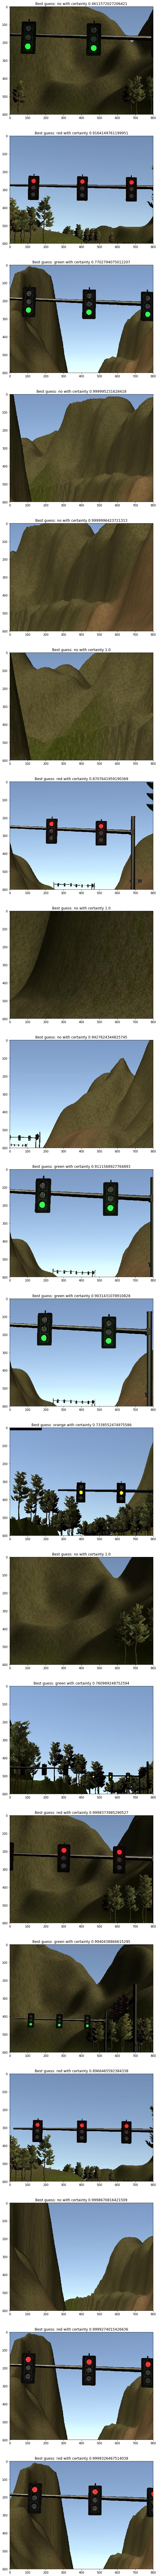

In [78]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from random import shuffle
import datetime
import glob
import os
import cv2

input_folder="D:/Projects/SDC/Term3/Capstone-Project-SDC-Term3-P3-Udacity/sim-recs/src/tl_detector/"
image_paths = glob.glob(os.path.join(input_folder, "*.jpg"))
shuffle(image_paths)

model_final.load_weights(model_name + "_1.h5")

start_time = datetime.datetime.now()
nr_images = 20
fig, axes = plt.subplots(nrows=nr_images, ncols=1, figsize=(28, 8 * nr_images))
print ("[INFO] program started on - " + str(start_time))
labels = list(train_generator.class_indices.keys())
print(labels)

for i, image_name in enumerate(image_paths[:nr_images]):
    im = cv2.imread(image_name)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = res_preprocess(im)
    im = np.expand_dims(im, axis =0)
    prob = model_final.predict(im)
    probs = prob[0]
    print(probs)
    j = np.argmax(prob,axis=1)[0]
    img=mpimg.imread(image_name)
    axes[i].imshow(img)
    axes[i].set_title(f'Best guess: {labels[j]} with certainty {probs[j]}')

end_time = datetime.datetime.now()
time_diff = end_time - start_time
print (f"Time to run: {time_diff}")